In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib
import os

In [ ]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')


GPU is available
Number of available GPUs: 1
GPU 0: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Project/Eye_diseases/dataset'
os.listdir(data_dir)

['glaucoma', 'diabetic_retinopathy', 'normal', 'cataract']

In [ ]:
tf.random.set_seed(42)

train_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'training', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

test_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'validation', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

Found 4237 files belonging to 4 classes.
Using 3814 files for training.
Found 4237 files belonging to 4 classes.
Using 423 files for validation.


In [ ]:
filenames = pathlib.Path(data_dir)
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

cataract : 1038
diabetic_retinopathy : 1108
glaucoma : 1017
normal : 1074


In [ ]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(239, 27)

In [ ]:
train_set = train_data.take(212)
val_set = train_data.skip(212)

In [ ]:
train_set.cardinality().numpy(), val_set.cardinality().numpy()

(212, 27)

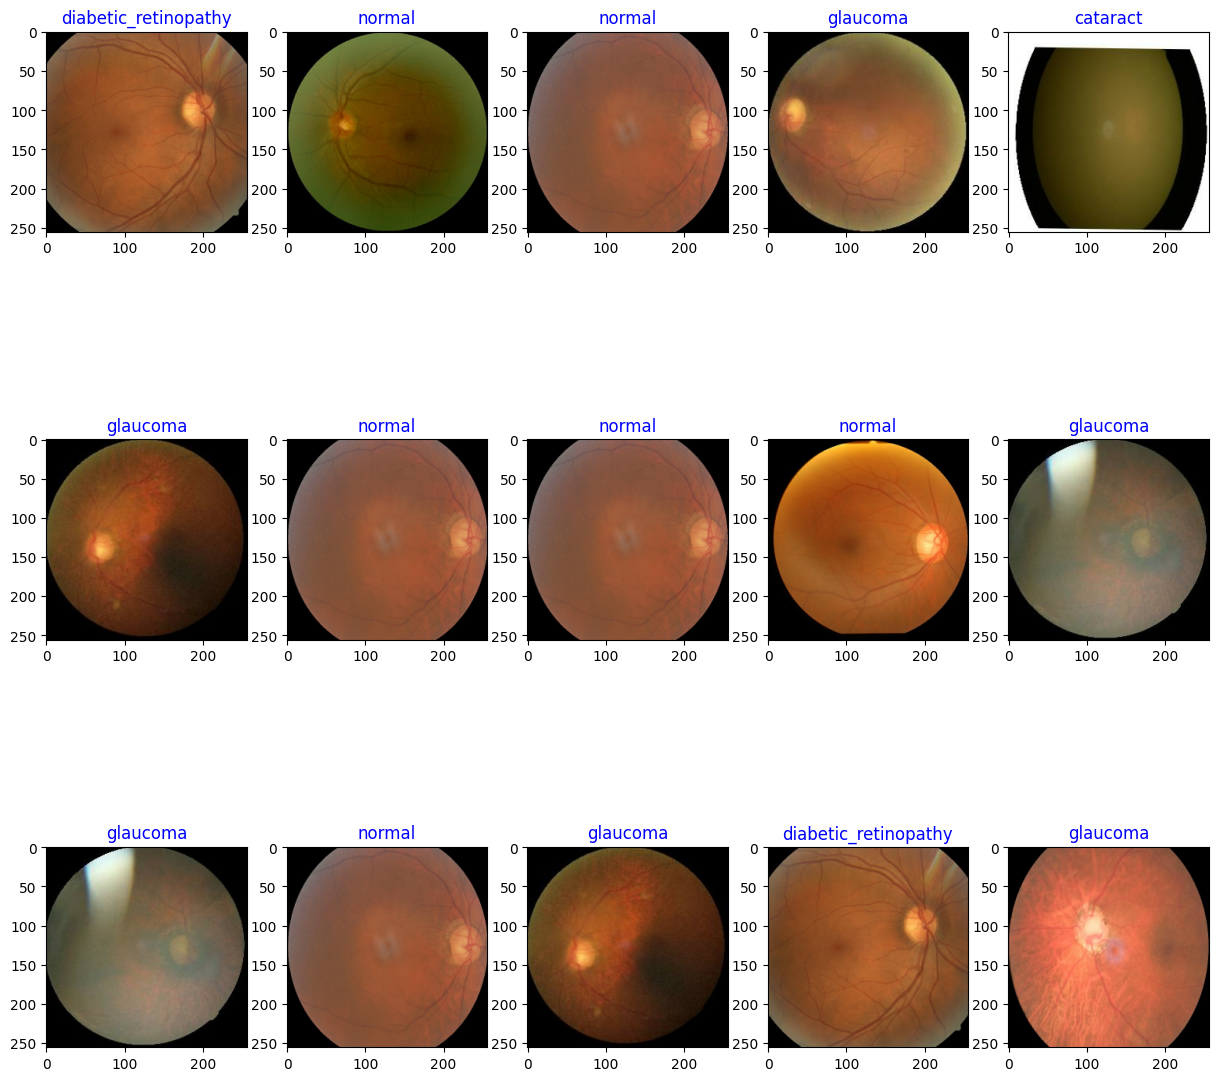

In [ ]:
# print random images from the train set
plt.figure(figsize = (15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color= 'blue', fontsize= 12)
        plt.axis(True)
plt.show()

In [ ]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=(128,128,3)), # Hidden Layer 1
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(32,(3,3), activation='relu'), # Hidden Layer 2
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(128,(3,3), activation='relu'), # Hidden Layer 3
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(), # Output layer
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, name ='feature_dense', activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
history_1 = model.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 734s 3s/step - accuracy: 0.4508 - loss: 1.3158 - val_accuracy: 0.6801 - val_loss: 0.6960
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 66s 311ms/step - accuracy: 0.6754 - loss: 0.7053 - val_accuracy: 0.7251 - val_loss: 0.6518
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.7276 - loss: 0.6198 - val_accuracy: 0.7441 - val_loss: 0.5502
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.7556 - loss: 0.5558 - val_accuracy: 0.7891 - val_loss: 0.5174
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 68s 320ms/step - accuracy: 0.7822 - loss: 0.5217 - val_accuracy: 0.7986 - val_loss: 0.4707
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 66s 310ms/step - accuracy: 0.8004 - loss: 0.4706 - val_accuracy: 0.7796 - val_loss: 0.4792
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 217ms/step - accuracy: 0.8317 - loss: 0.4158 - val_accuracy: 0.8294 - val_loss: 0.4153
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 66s 311ms/step - accuracy: 0.8250 - loss: 0.4

In [ ]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

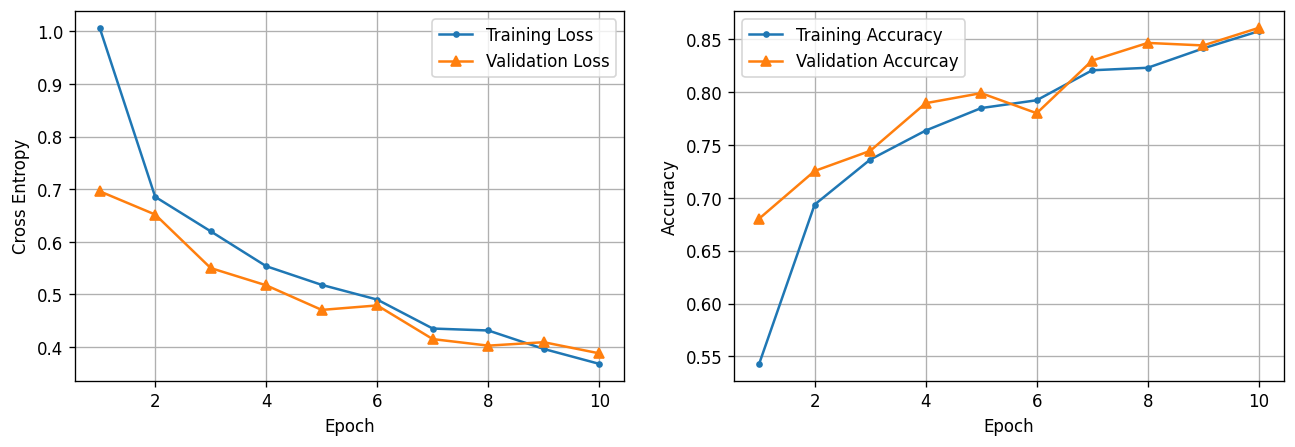

In [ ]:
plot_training_curves(pd.DataFrame(history_1.history))

In [ ]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)

X_test.shape, y_test.shape

(TensorShape([423, 256, 256, 3]), TensorShape([423]))

In [ ]:
from sklearn import metrics

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)
metrics.accuracy_score(y_test, y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


0.8368794326241135

In [ ]:
test_score = model.evaluate(test_data, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8734 - loss: 0.3374
Test Loss:  0.39473074674606323
Test Accuracy:  0.8368794322013855


In [ ]:
from sklearn.metrics import classification_report
target_names = ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
print(classification_report(y_test , y_pred, target_names=target_names))

                      precision    recall  f1-score   support

              normal       0.76      0.84      0.80        99
            glaucoma       1.00      0.98      0.99       115
diabetic_retinopathy       0.92      0.56      0.70       102
            cataract       0.73      0.94      0.82       107

            accuracy                           0.84       423
           macro avg       0.85      0.83      0.83       423
        weighted avg       0.86      0.84      0.83       423



In [ ]:
def plot_random_predictions(dataset, model):

    shuffled_data = dataset.shuffle(10)
    class_names = dataset.class_names

    for images, labels in shuffled_data.take(1):
        plt.figure(figsize = (10, 10), dpi = 120)
        y_pred_proba = model.predict(images)

    for i in range(9):
        index = random.randint(0, len(images))
        ax = plt.subplot(3,3, i + 1)

        img = images[index].numpy().astype("uint8")
        y_true = class_names[labels[index]]
        y_pred = class_names[np.argmax(y_pred_proba[index], axis = 0)]

        c = 'g' if y_pred == y_true else 'r'

        plt.imshow(img)
        plt.title(f'Predicted : {y_pred}\nTrue label : {y_true}', c = c)
        plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


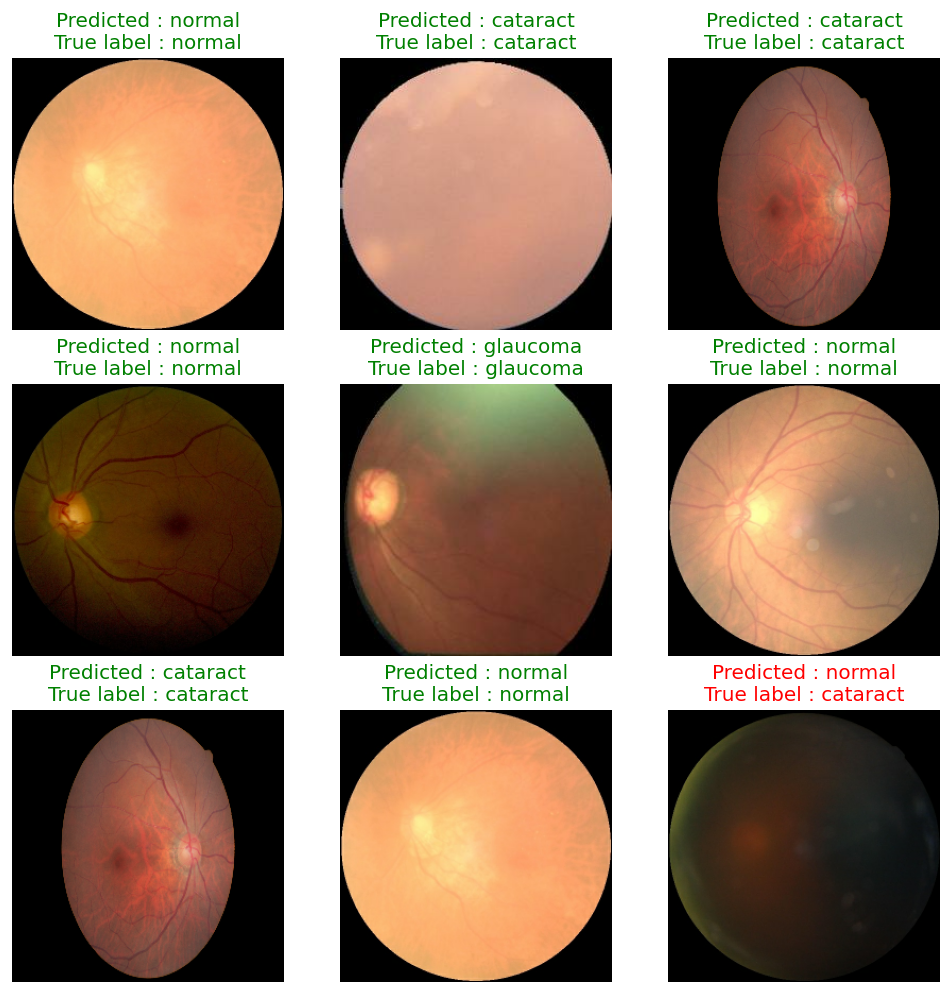

In [ ]:
plot_random_predictions(test_data, model)